In [1]:
import jax.numpy as jnp
import jax
import os

jax.config.update('jax_default_device',jax.devices()[1])
jax.config.update('jax_enable_x64',True)

from jsindy.trajectory_model import DataAdaptedRKHSInterpolant
from jsindy.sindy_model import JSINDyModel
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import LMSolver, AlternatingActiveSetLMSolver
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings


from equinox import tree_pprint
import matplotlib.pyplot as plt

from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp

import time


In [10]:
dt = 0.1
noise_var = 12.
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 500
expdata = LorenzExp(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=32,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

trajectory_model = DataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel()
optsettings = LMSettings(
    max_iter = 1000
)

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=AlternatingActiveSetLMSolver(beta_reg=0.001,solver_settings=optsettings),
    feature_names=expdata.feature_names
)
model.fit(
    expdata.t_train,
    expdata.x_train,
    expdata.t_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(9.26331873, dtype=float64), 'data_weight': Array(0.10783626, dtype=float64), 'colloc_weight': Array(10.7836259, dtype=float64)}
Warm Start


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 3.781e+07, gradnorm = 5.894e+09, alpha = 3.0, improvement_ratio = 0.4998
Iteration 1, loss = 2.222e+07, gradnorm = 4.709e+10, alpha = 3.0, improvement_ratio = 0.4124
Iteration 2, loss = 7.253e+06, gradnorm = 2.184e+10, alpha = 3.0, improvement_ratio = 0.6735
Iteration 3, loss = 7.832e+05, gradnorm = 1.974e+10, alpha = 2.5, improvement_ratio = 0.892
Iteration 4, loss = 6.411e+04, gradnorm = 6.663e+09, alpha = 2.083, improvement_ratio = 0.9182
Iteration 5, loss = 9.757e+03, gradnorm = 1.086e+09, alpha = 1.736, improvement_ratio = 0.8481
Iteration 200, loss = 18.21, gradnorm = 3.503e+04, alpha = 0.4206, improvement_ratio = 0.7527
Iteration 400, loss = 17.58, gradnorm = 7.751e+04, alpha = 0.3505, improvement_ratio = 0.799
Iteration 600, loss = 17.42, gradnorm = 135.8, alpha = 8.957e-06, improvement_ratio = 1.003
Iteration 800, loss = 17.42, gradnorm = 0.0002678, alpha = 8.333e-13, improvement_ratio = 0.9996
Iteration 999, loss = 17.42, gradnorm = 0.0001274, alpha = 8.33

In [11]:
model.print()

(x)' = -10.460 x + 10.221 y
(y)' = 27.997 x + -0.371 y + -1.026 x z
(z)' = 8.473 1 + -2.884 z + 0.929 x y


In [12]:
metrics

{'coeff_mets': {'precision': 0.875,
  'recall': 1.0,
  'f1': 0.9333333333333333,
  'coeff_rel_l2': 0.2700558078459218,
  'coeff_rmse': 1.554570271425755,
  'coeff_mae': 0.3366938662932254},
 'data_mets': {'mse': Array(21.64175821, dtype=float64),
  'rmse': np.float64(4.652070314870155),
  'mae': np.float64(3.228191914274443),
  'max_abs_error': np.float64(27.1721198324816),
  'normalized_mse': Array(0.00556294, dtype=float64),
  'relative_l2_error': np.float64(0.07457323291560373)}}

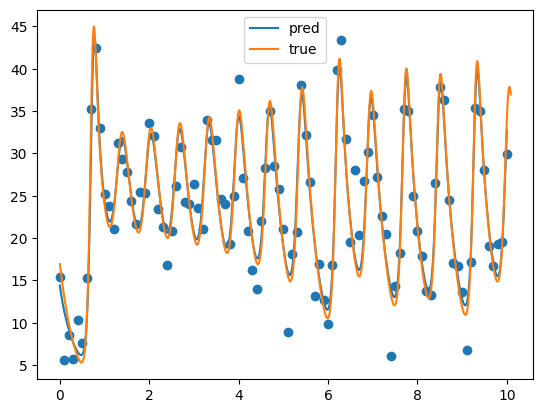

In [13]:
tgrid = jnp.linspace(0,10,500)
xpred = model.predict_state(tgrid)

index = 2
plt.plot(tgrid,xpred[:,index],label = 'pred')
plt.plot(expdata.t_true,expdata.x_true[:,index],label = 'true')

plt.scatter(expdata.t_train,expdata.x_train[:,index])
plt.legend()

In [ ]:
(expdata.t_train,jax.vmap(expdata.system_sol.evaluate)(expdata.t_train)[:,0])

Array([  0.37719066,  -0.01943533,  -0.17777103,  -0.44932008,
        -1.17085733,  -3.20027394,  -8.68437872, -17.50338725,
       -11.79457313,  -0.75066195,   3.64038269,   5.93787162,
         8.71513539,  11.28640203,  10.53761411,   7.27485277,
         5.27145372,   5.42447448,   7.42459532,  10.53121646,
        11.65630863,   8.71504781,   5.62201199,   4.77831144,
         5.9954803 ,   8.94572376,  11.89719827,  10.69283637,
         6.73515317,   4.55131564,   4.72800534,   6.86643679,
        10.53705932,  12.40864159,   9.02932472,   5.15040234,
         3.8904574 ,   4.81706233,   7.71984946,  11.84515793,
        12.23870343,   7.4674154 ,   3.98832705,   3.3080698 ,
         4.62418665,   8.00682223,  12.63162119,  12.28464055,
         6.58967599,   3.08079699,   2.42887473,   3.53444676,
         6.61310994,  11.99715574,  13.96971166,   7.65033569,
         2.62957007,   1.06802401,   1.05386261,   1.9240616 ,
         4.25694711,   9.63208483,  16.03627621,  10.70